# Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import math
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Loading Data

In [2]:
df = pd.read_csv('GOOGL.csv')

In [3]:
df.head()

,datetime,open,high,low,close,volume
0,2023-10-11,138.58000,141.11000,138.58000,140.55000,25850200
1,2023-10-10,138.50000,139.72000,137.33000,138.06000,27786600
2,2023-10-09,136.94000,138.94000,135.61000,138.42000,19278100
3,2023-10-06,134.00999,138.16000,134.00999,137.58000,27583200
4,2023-10-05,135.07001,135.49001,133.45000,135.07001,19832600


# Data Preprocessing

In [4]:
data = df['close'].loc[df['datetime']>'2010-01-01'].reset_index(drop=True)

In [5]:
data = data[::-1]

In [6]:
data = data.reset_index(drop = True)

In [7]:
data.head()

0    15.68443
1    15.61537
2    15.22172
3    14.86737
4    15.06557
Name: close, dtype: float64

In [8]:
data.tail()

3462    135.07001
3463    137.58000
3464    138.42000
3465    138.06000
3466    140.55000
Name: close, dtype: float64

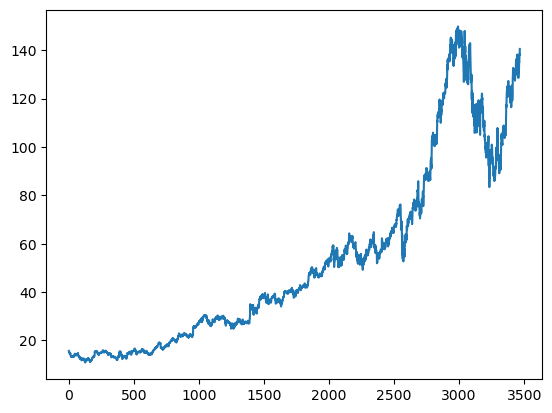

In [9]:
plt.plot(data)

In [10]:
stdscaler = StandardScaler()

In [11]:
data = stdscaler.fit_transform(np.array(data).reshape(-1,1))

In [12]:
training_size = int(0.8*len(data[:, 0]))
test_size = len(data[:, 0]) - training_size

In [13]:
training_size, test_size

(2773, 694)

In [14]:
train_data = data[0: training_size]
test_data = data[training_size: len(data[:, 0])]

In [15]:
def XySplit(data, time_window = 20):
    X = []
    y = []
    for i in range(0, len(data[:, 0])-time_window-1):
        X.append(data[i:i+time_window, 0])
        y.append(data[i+time_window, 0])
    return np.array(X), np.array(y)

In [16]:
time_window = 100

In [17]:
X_train, y_train = XySplit(train_data, time_window)
X_test, y_test = XySplit(test_data, time_window)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2672, 100), (2672,), (593, 100), (593,))

In [19]:
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.5))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1))

In [21]:
model.compile(loss ='mean_squared_error', optimizer = Adam(learning_rate = 0.0001))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

# Training

In [23]:
def trainer(epochs, verbose):
    model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=64, verbose=verbose)

In [24]:
def report():
    train_predict=stdscaler.inverse_transform(model.predict(X_train))
    test_predict=stdscaler.inverse_transform(model.predict(X_test))
    
    print(f'\n\nTrain RMSE Loss: {math.sqrt(mean_squared_error(y_train,train_predict))}')
    print(f'\n\nTest RMSE Loss: {math.sqrt(mean_squared_error(y_test,test_predict))}\n\n')
    print(f'\n\nTest MAPE Loss: {mean_absolute_percentage_error(y_test, test_predict)}\n\n')
    
    
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_window:len(train_predict)+time_window, :] = train_predict

    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_window*2)+1:len(data)-1, :] = test_predict
    
    plt.plot(stdscaler.inverse_transform(data), color = 'black')
    plt.plot(trainPredictPlot, color = 'blue')
    plt.plot(testPredictPlot, color = 'red')
    plt.legend(['Actual Data', 'Train Predict', 'Test Predict'])
    plt.title('Actual vs Predicted values')
    plt.figure(figsize = (19, 10))
    plt.show()
    
    plt.plot(stdscaler.inverse_transform(y_test.reshape(-1,1)), color = 'black')
    plt.plot(test_predict, color = 'red')
    plt.legend(['Actual Data', 'Test Predict'])
    plt.title('Actual Testing vs Predicted Testing values')
    plt.figure(figsize = (19, 10))
    plt.show()

In [39]:
trainer(100, 1)

Epoch 1/100
42/42 [==============================] - 12s 184ms/step - loss: 0.2432 - val_loss: 2.1129
Epoch 2/100
42/42 [==============================] - 8s 198ms/step - loss: 0.0477 - val_loss: 1.6581
Epoch 3/100
42/42 [==============================] - 11s 264ms/step - loss: 0.0337 - val_loss: 1.2661
Epoch 4/100
42/42 [==============================] - 11s 260ms/step - loss: 0.0268 - val_loss: 0.8913
Epoch 5/100
42/42 [==============================] - 10s 249ms/step - loss: 0.0227 - val_loss: 0.7075
Epoch 6/100
42/42 [==============================] - 11s 251ms/step - loss: 0.0224 - val_loss: 0.6074
Epoch 7/100
42/42 [==============================] - 10s 248ms/step - loss: 0.0203 - val_loss: 0.5189
Epoch 8/100
42/42 [==============================] - 10s 246ms/step - loss: 0.0192 - val_loss: 0.4864
Epoch 9/100
42/42 [==============================] - 11s 251ms/step - loss: 0.0188 - val_loss: 0.3997
Epoch 10/100
42/42 [==============================] - 11s 251ms/step - loss: 0.0177

# Result Analysis

19/19 [==============================] - 1s 27ms/step


Train RMSE Loss: 42.306807104247085


Test RMSE Loss: 120.186529630689




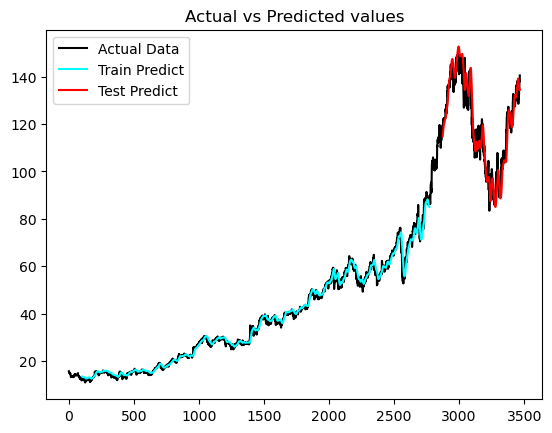

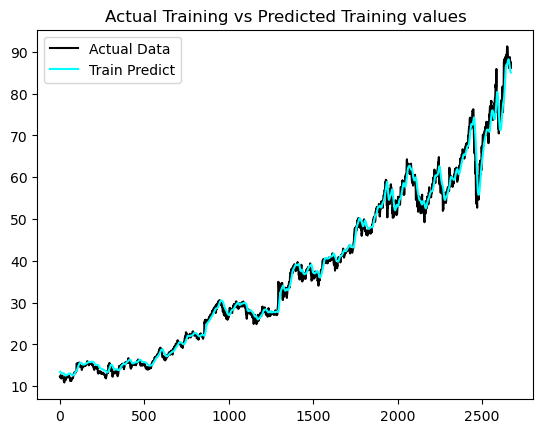

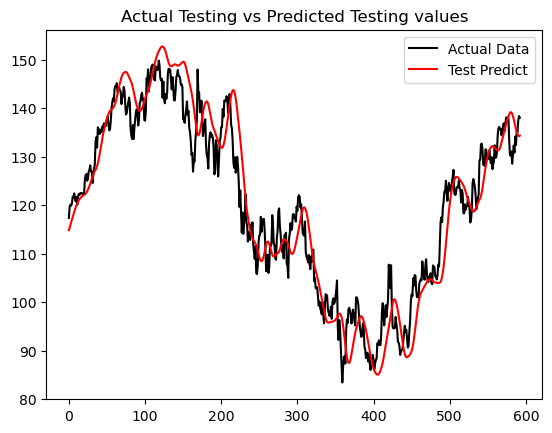

In [40]:
report()

In [41]:
model.save('GOOGLmodel.h5')

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
epochs_list = [25, 50]

epochs: 25
19/19 [==============================] - 1s 40ms/step


Train RMSE Loss: 42.510311264386516


Test RMSE Loss: 104.50951468794871




Test MAPE Loss: 62.04097744414024




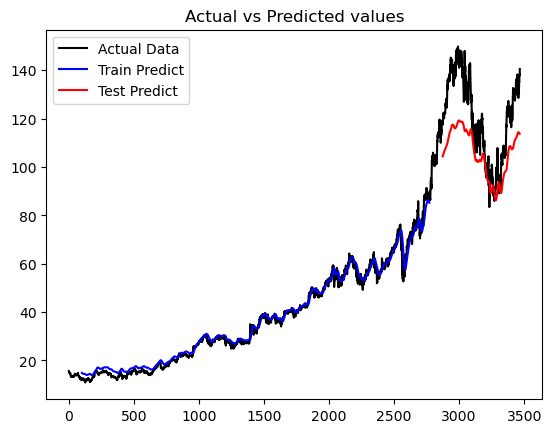

<Figure size 1900x1000 with 0 Axes>

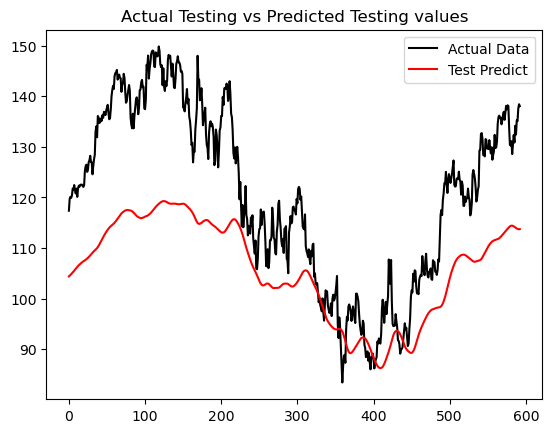

<Figure size 1900x1000 with 0 Axes>

epochs: 50
19/19 [==============================] - 1s 41ms/step


Train RMSE Loss: 42.2764276217418


Test RMSE Loss: 115.66662254470901




Test MAPE Loss: 67.43099971330086




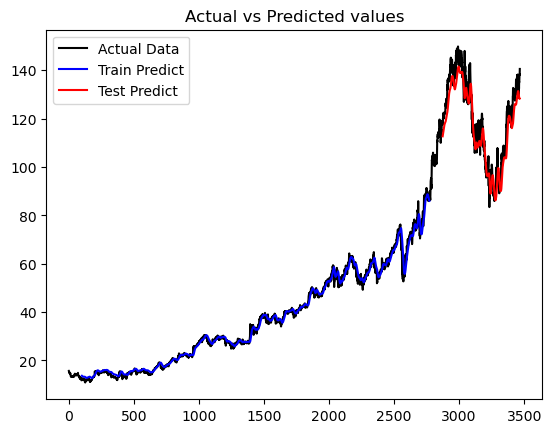

<Figure size 1900x1000 with 0 Axes>

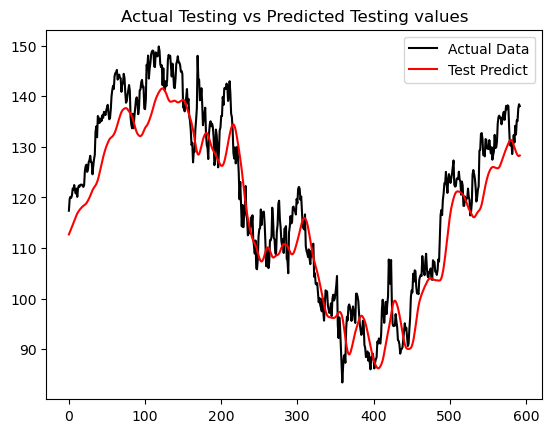

<Figure size 1900x1000 with 0 Axes>

In [26]:
for epochs in epochs_list:
    print(f'epochs: {epochs}')
    trainer(epochs, 0)
    report()

In [29]:
model = load_model("GOOGLmodel.h5")

19/19 [==============================] - 1s 28ms/step


Train RMSE Loss: 42.306807104247085


Test RMSE Loss: 120.186529630689




Test MAPE Loss: 69.30883422213356




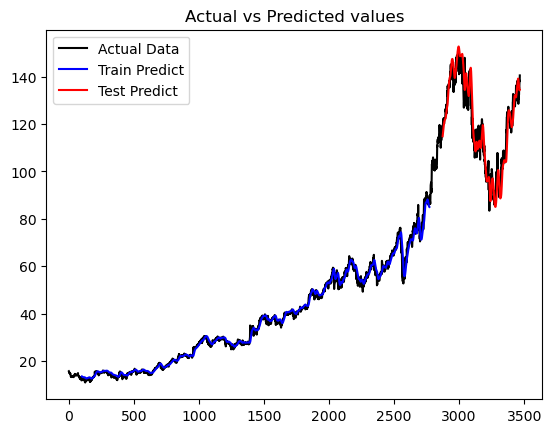

<Figure size 1900x1000 with 0 Axes>

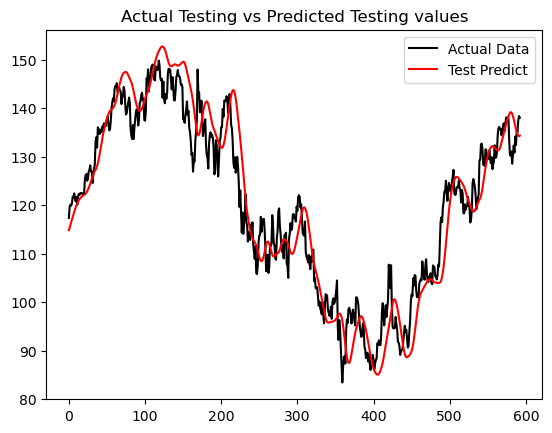

<Figure size 1900x1000 with 0 Axes>

In [30]:
report()

In [2]:
loaded_model = load_model("GOOGLmodel.h5")

In [3]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [39]:
#R4Z0Rx